<a href="https://colab.research.google.com/github/dylanbforde/ai-medical-image-analysis/blob/main/MRNet_tutorial_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TO DO:** Make a copy of this notebook in your own Google drive and edit the copy.

**TO DO:** Download the data at the following link https://stanfordmlgroup.github.io/competitions/mrnet/ and upload it to your Google Drive.

This will download a folder named 'data'.

*   The dataset consists of 1,250 knee MRIs with image level labels.
*   The training data consists of 1,130 MRIs and the validation data consists of 120 MRIs.
*   They are labelled as abnormal, having an acl tear and/or meniscus tear.
*   Each MRI exam includes data from the axial, coronal and sagittal plane.
*   Axial is a Proton-Density series, coronal is a T1-weighted series and sagittal is T2-weighted series.






Go to "Edit" on the toolbar, then "Notebook Settings" and change the hardware accelerator to GPU.


#Mount Google Drive to access your data



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


The following code uses a python library named 'torchsample'. This is not installed in Google Colab. We can import it by running the commands in the following cell. The exclamation mark communicates to Google Colab to run the commands in the terminal rather than in Python in the current notebook.


In [ ]:
!pip install torchsample
!pip install visdom
!pip install nibabel
!pip install h5py
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.6/393.6 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchsample: filename=torchsample-0.1.0-py3-none-any.whl size=16698 sha256=721547ae177a1b6b82366f2a6f606e4739071ec41b641ff2953153d69becef69
  Stored in directory: /root/.cache/pip/wheels/c6/c8/b6/19457b219a37c931e360e7bce0e014e92422de1f6257d1a49d
Successfully built torchsample
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408288 sha256=73e4e8d7736a34e7946b5129a69e06cebd61ee747d3e55f83b2698bf6461e124
  Stored in directory: /root/.cache/pip/wheels/fa/a4/bb/2be445c295d88a74f9c0a4232f04860ca489a5c7c57eb959d9
Successfully 

In [ ]:
#import all libraries
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import os
import sys
import pickle
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from torch.autograd import Variable
from torchvision import transforms
from tensorboardX import SummaryWriter
import math
from sklearn import metrics

#Define your model
The model is defined in the class 'Net'. The 'init' function initialises the architecture of the model.

The line of code; ```self.pretrained_model = models.resnet18(pretrained=True)``` initialises a pre-trained ResNet18, pre-trained on the ImageNet Dataset. This initialises the weights of the model with the weights for a ResNet18 model that was trained on the ImageNet dataset. This speeds up training.

The line of code ```self.classifer = nn.Linear(1000, 1)``` is a fully connected layer that makes the final prediction.

After the model is initialised, the forward function is called iteratively throughout the training process. The output size of each line is shown in the code.

More information con defining models can be found at https://pytorch.org/vision/stable/models.html

In [ ]:
models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
list( models.resnet18(pretrained=True).children())[:-1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
#modify the last fully connected layer to output (1) instead of (1000)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model =  nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1]  )    # delete the last fc layer.
        self.classifer = nn.Linear(512, 1)


    def forward(self, x):
        # input size of x (1, s, 3, 256, 256) where s is the number of slices in one MRI
        x = torch.squeeze(x, dim=0) #output size (s, 3, 256, 256)
        x = self.pretrained_model(x) #output size (s, 512)
        output = torch.max(x, 0, keepdim=True)[0] #output size (1, 512)
        output = self.classifer(output.squeeze(2).squeeze(2)) #output size (1)

        return output

In [ ]:
#add another fully connected layer to convert output (1,1000) to (1)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model =  models.resnet18(pretrained=True)   # delete the last fc layer.
        self.classifer = nn.Linear(1000, 1)


    def forward(self, x):
        # input size of x (batch_size, s, 3, 256, 256) where s is the number of slices in one MRI
        batch_size, num_slices, channels, height, width = x.size()
        # Reshape the input to process slices individually
        x = x.view(-1, channels, height, width) # output size (batch_size * num_slices, 3, 256, 256)

        x = self.pretrained_model(x) # output size (batch_size * num_slices, 1000)
        x = x.view(batch_size, num_slices, -1) # output size (batch_size, num_slices, 1000)

        output = torch.max(x, 1, keepdim=True)[0] # output size (batch_size, 1, 1000)
        output =nn.ReLU()(output)
        output = self.classifer(output.squeeze(1)) # output size (batch_size, 1)

        return output

In [ ]:
mod=Net()
mod

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Net(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

TO NOTE:
Models defined in Pytorch expect 2D image data in the dimensions (batch size, channels (colours), height of the image, width of the image)

#Create Dataloader
The 'init' function initialises the dataloader. This class is responsible for loading the datasets. It takes the 'root_dir', 'task', 'plane', 'train' and 'transform' as input parameters.
root_dir - the directory to where the data is stored.

task - whether the model is being trained to detect acl tears, meniscus tears or abnormalities. Possible values are 'acl', 'meniscus' or 'abnormal'.

plane - whether the model is being trained on axial, coronal or sagittal data. Possible values are 'axial', 'coronal' or 'sagittal'.

train - is this the dataloader for the training data or the validation data. Possible values are 'True' to load training data or 'False' to load validation data.

transform - a compose function for performing transformations to the images.

The init function creates 1) a list of paths to each MRI, 2) a corresponding list of labels that are either ones or zeros and 3) weights.


---



The __len__ function returns the length of the dataset.


---
The __getitem__ function is iteratively called throughout the training process. It takes an index as a input parameter. It loads the MRI at the given index from the list of paths defined in the init function. It also returns the label and weight for the MRI at that index.



In [ ]:
class Dataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=False, transform=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train=train
        if self.train == True:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)

            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform

        pos = np.sum(self.labels)
        neg = len(self.labels) - pos
        self.weights = [1, neg / pos]


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])

        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:
          transformed_slices = []
          for i in array:
            transformed_slice = self.transform(i)
            transformed_slice = transformed_slice.repeat(3, 1, 1)
            transformed_slices.append(transformed_slice)
          array = torch.stack(transformed_slices)
        else:
          array = torch.from_numpy(array).float()
          array = array.unsqueeze(1)
          array = array.repeat(1, 3, 1, 1)

        array = array.float()

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        if array.shape[0] < 32:
            zeros = torch.zeros((32 - array.shape[0], 3, 256, 256))
            array = torch.cat((array, zeros), 0)

        elif array.shape[0] > 32:
            array = array[:32, :, :, :]

        return array, label, weight

#Train the model
##Define variables
**TO DO:** Change directory to where you store your data. Use the toolbar to the side of this page to view your file system.

In [ ]:
directory = "/content/drive/Shared drives/MRNet Group Assignment/MRI Data/"
task = 'acl'
plane = 'sagittal'
lr = 1e-5 #learning rate
num_epochs = 50 # number of epochs

##Initialise the model, optimiser, scheduler, transformations and data loader.

In [ ]:

model = Net() #initialise the model
if torch.cuda.is_available(): #if there is a GPU available, put the model on the GPU
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr= lr, weight_decay=0.1) #define the optimiser as Adam

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=4, factor=.3, threshold=1e-4, verbose=True) #define a scheduler that decreases the learning rate if there has been no reduction in validation loss is four epochs

#define a compose function that is a series of transformations on the images.
augmentor = transforms.Compose([
    # 1. numpy / PIL  ➜  float32 tensor in [0, 1]
    transforms.ToTensor(),

    # 2. ± 25° random rotation (keeps image size)
    transforms.RandomRotation(25),

    # 3. Random translation: up to 11 % of width & height
    transforms.RandomAffine(
        degrees=0,                 # no extra rotation here
        translate=(0.11, 0.11)
    ),

    # 4. Random left-right flip
    transforms.RandomHorizontalFlip()
])

#initialise the train and validation datasets (class we defined earlier) and then initialise a Pytorch's dataloader
train_dataset = Dataset(directory, task, plane,
                         train=True, transform=augmentor)
valid_dataset = Dataset(
      directory, task, plane, train=False, transform = None)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=10, shuffle=True, num_workers=2, drop_last=False)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=10, shuffle=False, num_workers=2, drop_last=False)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


##Training Loop

In [ ]:
import logging

# Configure logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # Removed logging configuration

early_trigger = 10 #if the validation AUC hasn't increased in ten epochs, stop the training
early_stop = 0 #counter for the number of iterations where there has been no increase in validation AUC
best_val_auc = 0
#for loop for each epoch
for epoch in range(num_epochs):
      print(f"Starting epoch {epoch+1}/{num_epochs}")
      #get learning rate
      current_lr = lr

      y_preds = []
      y_trues = []
      losses = []
      _ = model.train()
      print("Starting training phase") # Changed to print
      #loop through each MRI in the training set
      for i, (image, label, weight) in enumerate(train_loader):
          print(f"Training batch {i+1}/{len(train_loader)}") # Changed to print
          optimizer.zero_grad()

          #load all data onto the GPU
          if torch.cuda.is_available():
              image = image.cuda()
              label = label.cuda()
              weight = weight.cuda()

          #pass the MRI through the model
          prediction = model.forward(image.float())

          #calculate the loss
          loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
          loss.backward() #back propagation
          optimizer.step()

          loss_value = loss.item()
          losses.append(loss_value)

          probas = torch.sigmoid(prediction) #convert output of model (logits) to a value between zero and one. This can be interpretted as a probability

          y_trues.extend(label.cpu().tolist())
          y_preds.extend(probas.cpu().tolist())

          try:
              auc = metrics.roc_auc_score(y_trues, y_preds)
          except:
              auc = 0.5

          train_loss = np.round(np.mean(losses), 4)
          train_auc = np.round(auc, 4)

      #evaluate the model on the validation data after each epoch
      _ = model.eval()
      y_trues = []
      y_preds = []
      losses = []
      print("Starting validation phase") # Changed to print
      for i, (image, label, weight) in enumerate(valid_loader):
        print(f"Validation batch {i+1}/{len(valid_loader)}") # Changed to print
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()


        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.extend(label.cpu().tolist())
        y_preds.extend(probas.cpu().tolist())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        val_loss = np.round(np.mean(losses), 4)
        val_auc = np.round(auc, 4)

      if val_auc > best_val_auc:
        best_val_auc = val_auc
        early_stop=0
      else:
        early_stop+= 1

      if early_stop == early_trigger:
        print('Early stopping after {} epochs'.format(epoch))
        sys.exit()
      scheduler.step(val_loss)

      print("epoch : {0} | train loss : {1} | train auc {2} | val loss {3} | val auc {4} ".format(
          epoch, train_loss, train_auc, val_loss, val_auc))


      print('-' * 30)

Starting epoch 1/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Training batch 31/113
Training batch 32/113
Training batch 33/113
Training batch 34/113
Training batch 35/113
Training batch 36/113
Training batch 37/113
Training batch 38/113
Training batch 39/113
Training batch 40/113
Training batch 41/113
Training batch 42/113
Training batch 43/113
Training batch 44/1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 0 | train loss : 1.2124 | train auc 0.6044 | val loss 22.731 | val auc 0.6706 
------------------------------
Starting epoch 2/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Training

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 1 | train loss : 1.0014 | train auc 0.7202 | val loss 32.2786 | val auc 0.6888 
------------------------------
Starting epoch 3/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Trainin

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 2 | train loss : 0.9387 | train auc 0.7767 | val loss 27.1689 | val auc 0.6765 
------------------------------
Starting epoch 4/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Trainin

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 3 | train loss : 0.9348 | train auc 0.7767 | val loss 22.8452 | val auc 0.6588 
------------------------------
Starting epoch 5/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Trainin

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 4 | train loss : 0.8829 | train auc 0.8064 | val loss 23.8566 | val auc 0.6505 
------------------------------
Starting epoch 6/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Trainin

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 5 | train loss : 0.8428 | train auc 0.831 | val loss 18.3136 | val auc 0.5819 
------------------------------
Starting epoch 7/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Training

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 6 | train loss : 0.8335 | train auc 0.8311 | val loss 18.9061 | val auc 0.5871 
------------------------------
Starting epoch 8/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Trainin

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 7 | train loss : 0.7858 | train auc 0.8514 | val loss 24.7911 | val auc 0.5769 
------------------------------
Starting epoch 9/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Trainin

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12
Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 8 | train loss : 0.785 | train auc 0.8518 | val loss 22.0034 | val auc 0.554 
------------------------------
Starting epoch 10/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 9 | train loss : 0.7438 | train auc 0.8741 | val loss 16.2635 | val auc 0.515 
------------------------------
Starting epoch 11/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Trainin

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
epoch : 10 | train loss : 0.7206 | train auc 0.8819 | val loss 14.8618 | val auc 0.5271 
------------------------------
Starting epoch 12/50
Starting training phase
Training batch 1/113
Training batch 2/113
Training batch 3/113
Training batch 4/113
Training batch 5/113
Training batch 6/113
Training batch 7/113
Training batch 8/113
Training batch 9/113
Training batch 10/113
Training batch 11/113
Training batch 12/113
Training batch 13/113
Training batch 14/113
Training batch 15/113
Training batch 16/113
Training batch 17/113
Training batch 18/113
Training batch 19/113
Training batch 20/113
Training batch 21/113
Training batch 22/113
Training batch 23/113
Training batch 24/113
Training batch 25/113
Training batch 26/113
Training batch 27/113
Training batch 28/113
Training batch 29/113
Training batch 30/113
Train

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 2/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 3/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 4/12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Validation batch 5/12
Validation batch 6/12
Validation batch 7/12
Validation batch 8/12
Validation batch 9/12
Validation batch 10/12
Validation batch 11/12
Validation batch 12/12
Early stopping after 11 epochs


SystemExit: 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


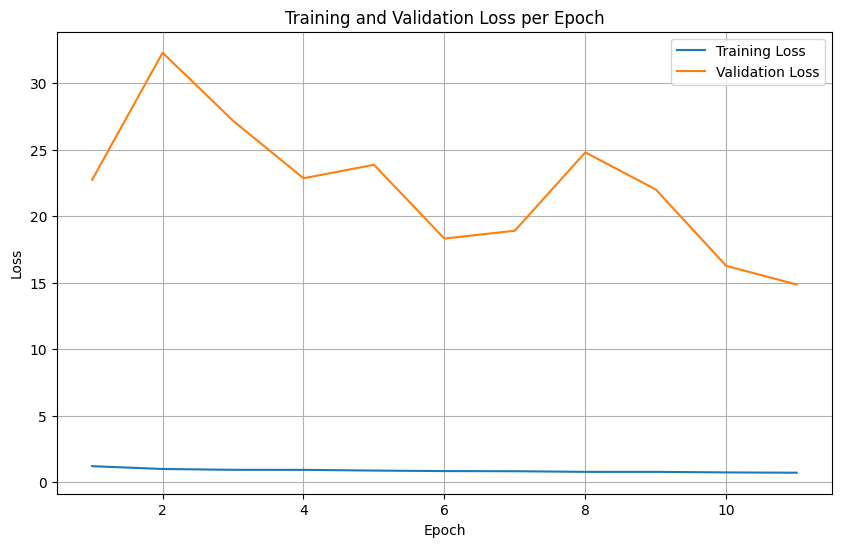

In [ ]:
import matplotlib.pyplot as plt
import re

training_output = """
epoch : 0 | train loss : 1.2124 | train auc 0.6044 | val loss 22.731 | val auc 0.6706
epoch : 1 | train loss : 1.0014 | train auc 0.7202 | val loss 32.2786 | val auc 0.6888
epoch : 2 | train loss : 0.9387 | train auc 0.7767 | val loss 27.1689 | val auc 0.6765
epoch : 3 | train loss : 0.9348 | train auc 0.7767 | val loss 22.8452 | val auc 0.6588
epoch : 4 | train loss : 0.8829 | train auc 0.8064 | val loss 23.8566 | val auc 0.6505
epoch : 5 | train loss : 0.8428 | train auc 0.831 | val loss 18.3136 | val auc 0.5819
epoch : 6 | train loss : 0.8335 | train auc 0.8311 | val loss 18.9061 | val auc 0.5871
epoch : 7 | train loss : 0.7858 | train auc 0.8514 | val loss 24.7911 | val auc 0.5769
epoch : 8 | train loss : 0.785 | train auc 0.8518 | val loss 22.0034 | val auc 0.554
epoch : 9 | train loss : 0.7438 | train auc 0.8741 | val loss 16.2635 | val auc 0.515
epoch : 10 | train loss : 0.7206 | train auc 0.8819 | val loss 14.8618 | val auc 0.5271
"""

train_losses_extracted = []
val_losses_extracted = []

loss_pattern = re.compile(r'epoch : \d+ \| train loss : (\d+\.?\d*) \| .* \| val loss (\d+\.?\d*)')

for line in training_output.splitlines():
    match = loss_pattern.search(line)
    if match:
        train_loss = float(match.group(1))
        val_loss = float(match.group(2))
        train_losses_extracted.append(train_loss)
        val_losses_extracted.append(val_loss)

# Plot the losses
epochs = range(1, len(train_losses_extracted) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_extracted, label='Training Loss')
plt.plot(epochs, val_losses_extracted, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Examples of Classifications:
------------------------------
Correct Classifications:
Example 1: Predicted Probability = 0.0000, True Label = 0


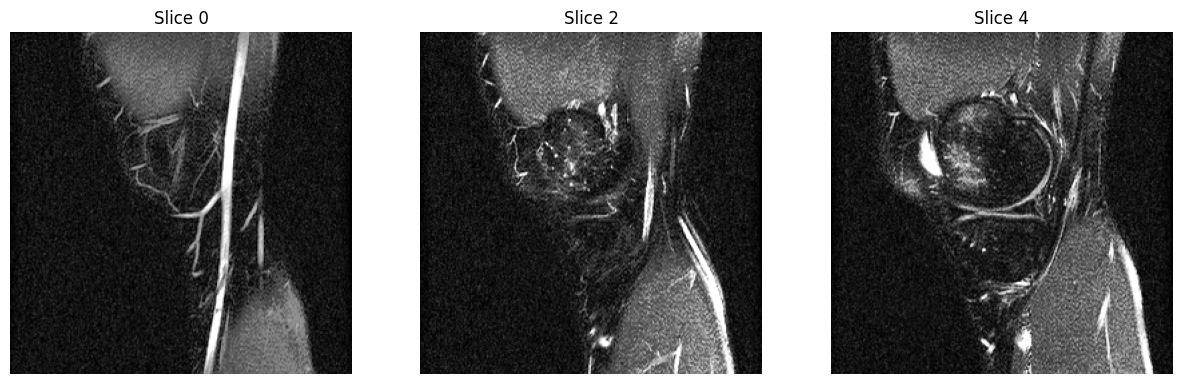

------------------------------
Example 2: Predicted Probability = 0.0000, True Label = 0


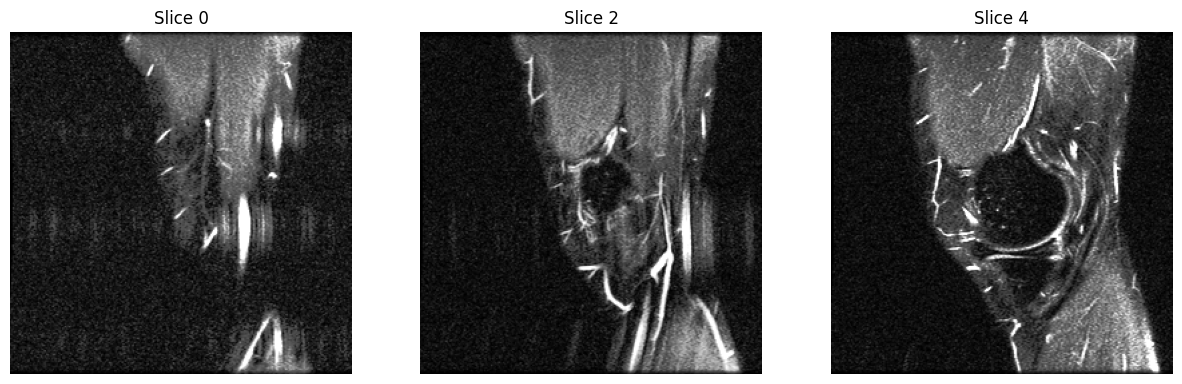

------------------------------
Example 3: Predicted Probability = 0.0000, True Label = 0


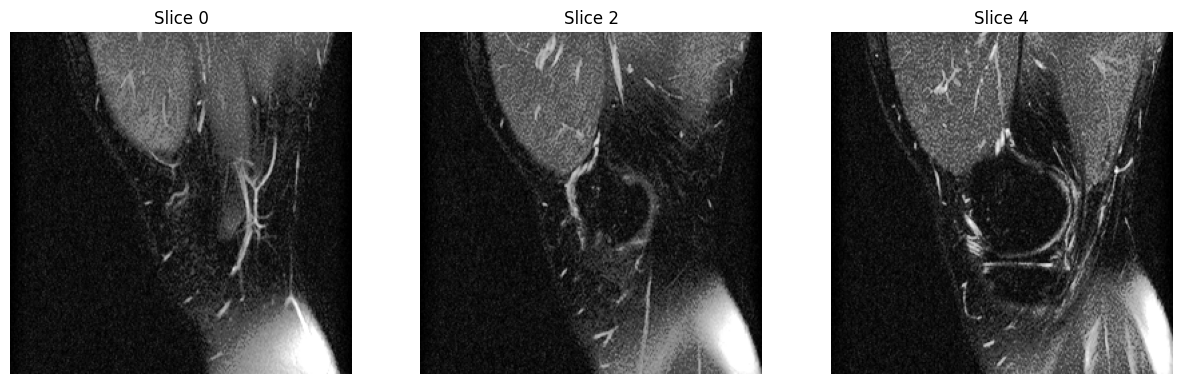

------------------------------
Incorrect Classifications:
Example 1: Predicted Probability = 0.5021, True Label = 0


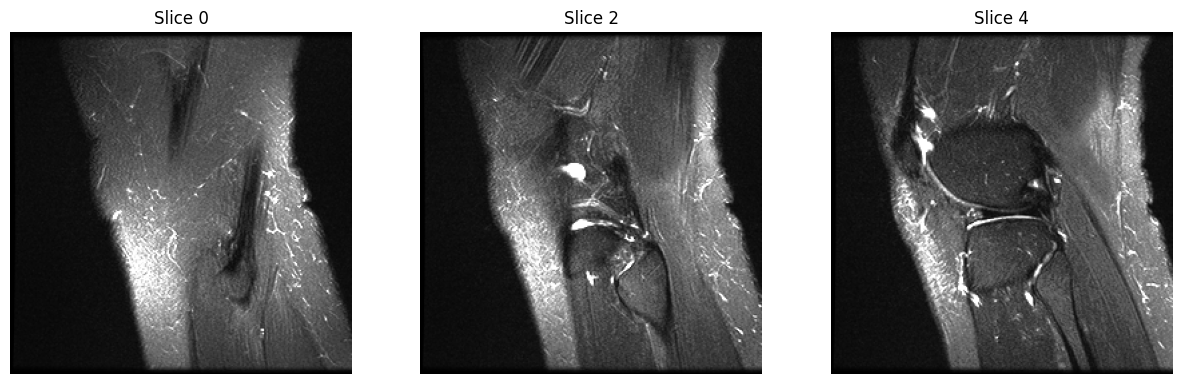

------------------------------
Example 2: Predicted Probability = 0.7605, True Label = 0


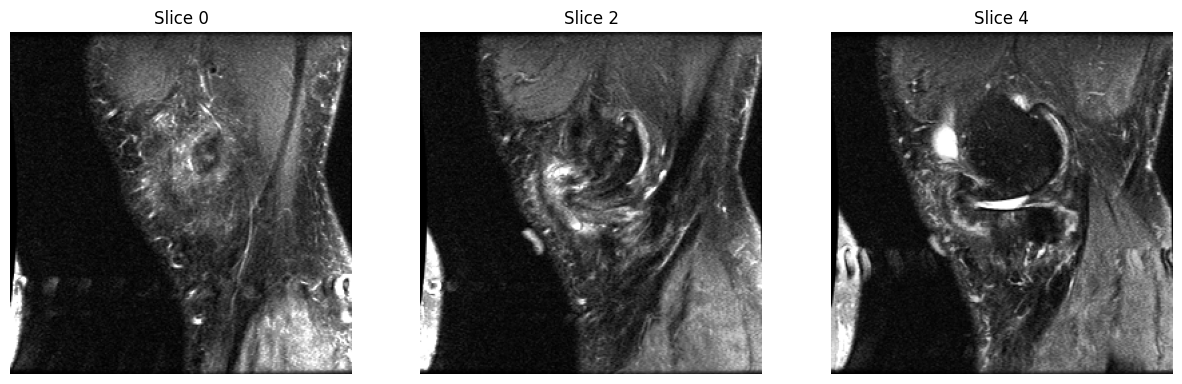

------------------------------
Example 3: Predicted Probability = 0.7076, True Label = 0


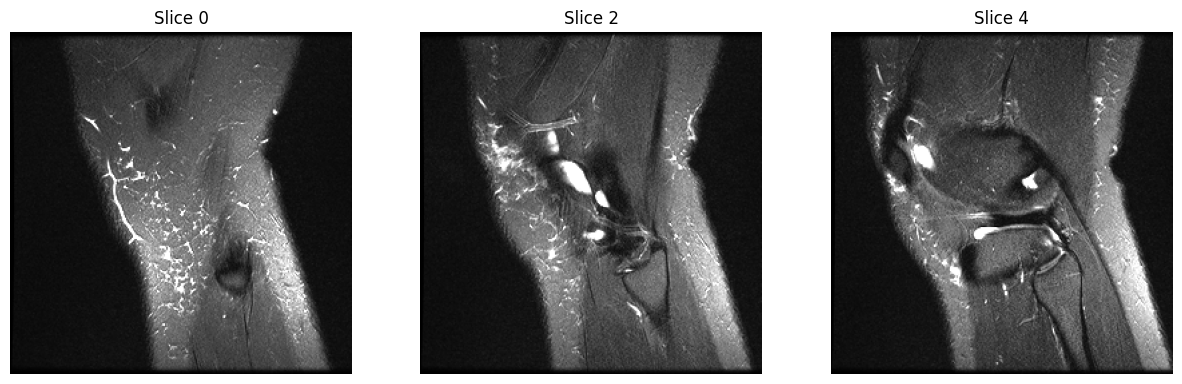

------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Set the model to evaluation mode
model.eval()

y_trues = []
y_preds = []
examples = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for i, (image, label, weight) in enumerate(valid_loader):
        if torch.cuda.is_available():
            # Keep image on GPU for prediction, but will move to CPU for display later
            image_gpu = image.cuda()
        else:
            image_gpu = image

        prediction = model.forward(image_gpu.float())
        probas = torch.sigmoid(prediction)

        y_trues.extend(label.cpu().tolist())
        y_preds.extend(probas.cpu().tolist())

        # Store examples with predictions, true labels, and the image data (on CPU)
        for j in range(image.size(0)):
            examples.append({
                'predicted_proba': probas[j].item(),
                'true_label': label[j].item(),
                'image': image[j].cpu().numpy() # Store image data on CPU
            })

# Display some examples
print("Examples of Classifications:")
print("-" * 30)

# Display a few correct classifications
print("Correct Classifications:")
correct_examples = [ex for ex in examples if (ex['predicted_proba'] > 0.5 and ex['true_label'] == 1.0) or (ex['predicted_proba'] <= 0.5 and ex['true_label'] == 0.0)]
for i, ex in enumerate(correct_examples[:3]): # Display up to 3 correct examples
    print(f"Example {i+1}: Predicted Probability = {ex['predicted_proba']:.4f}, True Label = {int(ex['true_label'])}")
    img_data = ex['image'] # Shape is (num_slices, channels, height, width)
    num_slices = img_data.shape[0]
    # Display a few slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    slices_to_show = [0, 2, 4] # Display first, third, and fifth slices
    for k, slice_idx in enumerate(slices_to_show):
        if slice_idx < num_slices:
            # Assuming grayscale image with 3 repeated channels, take one channel
            axes[k].imshow(img_data[slice_idx, 0, :, :], cmap='gray')
            axes[k].set_title(f"Slice {slice_idx}")
            axes[k].axis('off')
    plt.show()
    print("-" * 30)


# Display a few incorrect classifications
print("Incorrect Classifications:")
incorrect_examples = [ex for ex in examples if (ex['predicted_proba'] > 0.5 and ex['true_label'] == 0.0) or (ex['predicted_proba'] <= 0.5 and ex['true_label'] == 1.0)]
for i, ex in enumerate(incorrect_examples[:3]): # Display up to 3 incorrect examples
    print(f"Example {i+1}: Predicted Probability = {ex['predicted_proba']:.4f}, True Label = {int(ex['true_label'])}")
    img_data = ex['image'] # Shape is (num_slices, channels, height, width)
    num_slices = img_data.shape[0]
    # Display a few slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    slices_to_show = [0, 2, 4] # Display first, third, and fifth slices
    for k, slice_idx in enumerate(slices_to_show):
         if slice_idx < num_slices:
            axes[k].imshow(img_data[slice_idx, 0, :, :], cmap='gray')
            axes[k].set_title(f"Slice {slice_idx}")
            axes[k].axis('off')
    plt.show()
    print("-" * 30)

# Save the trained model
Save the model's state dictionary so you can load it later without retraining. Remember to specify a path in your mounted Google Drive to save it persistently.

In [ ]:
# Define the path to save the model (change 'my_model.pth' to your desired filename and path)
model_save_path = '/content/drive/MyDrive/my_acl_sagittal_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/MyDrive/my_acl_sagittal_model.pth


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 55.8 MB/s eta 0:00:00


modifying




In [ ]:
# Modify the Net class to include a Dropout layer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pretrained ResNet18 model
        self.pretrained_model = models.resnet18(pretrained=True)
        # Modify the last fully connected layer to output (1)
        self.classifer = nn.Linear(self.pretrained_model.fc.in_features, 1)
        # Add a Dropout layer after the classifier
        self.dropout = nn.Dropout(0.5) # Experiment with a dropout rate of 0.5

        # Remove the original fully connected layer from the pretrained model
        self.pretrained_model.fc = nn.Identity()


    def forward(self, x):
        # input size of x (batch_size, s, 3, 256, 256) where s is the number of slices in one MRI
        batch_size, num_slices, channels, height, width = x.size()
        # Reshape the input to process slices individually
        x = x.view(-1, channels, height, width) # output size (batch_size * num_slices, 3, 256, 256)

        x = self.pretrained_model(x) # output size (batch_size * num_slices, 512)

        # Reshape back to include the number of slices
        x = x.view(batch_size, num_slices, -1) # output size (batch_size, num_slices, 512)

        # Apply max pooling across the slices
        output = torch.max(x, 1, keepdim=True)[0] # output size (batch_size, 1, 512)

        # Remove the extra dimension from keepdim=True and pass through classifier
        output = self.classifer(output.squeeze(1)) # output size (batch_size, 1)

        # Apply dropout
        output = self.dropout(output)

        return output

# Re-initialize the model with the new architecture
model = Net()
if torch.cuda.is_available():
    model = model.cuda()

# Keep the existing optimizer, scheduler, and data loaders
# (These are defined in the previous cells and will be used in the training loop)

print("Model architecture modified to include Dropout layer.")
print(model)

Model architecture modified to include Dropout layer.
Net(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Batc

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=False, transform=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train=train
        if self.train == True:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)

            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform

        pos = np.sum(self.labels)
        neg = len(self.labels) - pos
        self.weights = [1, neg / pos]


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])

        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:
          transformed_slices = []
          for i in array:
            transformed_slice = self.transform(i)
            transformed_slice = transformed_slice.repeat(3, 1, 1)
            transformed_slices.append(transformed_slice)
          array = torch.stack(transformed_slices)
        else:
          array = torch.from_numpy(array).float()
          array = array.unsqueeze(1)
          array = array.repeat(1, 3, 1, 1)

        array = array.float()

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        if array.shape[0] < 32:
            zeros = torch.zeros((32 - array.shape[0], 3, 256, 256))
            array = torch.cat((array, zeros), 0)

        elif array.shape[0] > 32:
            array = array[:32, :, :, :]

        return array, label, weight

The Net class has been updated to include a Dropout layer


In [ ]:
import optuna
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import os
import sys
import pickle
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from torch.autograd import Variable
from torchvision import transforms
from tensorboardX import SummaryWriter
import math
from sklearn import metrics

def objective(trial):
    # Define the hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-6, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32]) # Example batch sizes
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6) # Tune dropout rate
    trial_number = trial.number

    # --- Model Initialization ---
    model = Net()
    # Update the dropout rate in the model with the suggested value from Optuna
    model.dropout.p = dropout_rate

    if torch.cuda.is_available():
        model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=2, factor=.3, threshold=1e-4, verbose=False) # Reduced patience for tuning

    # --- Data Loading ---
    directory = "/content/drive/Shared drives/MRNet Group Assignment/MRI Data/"
    task = 'acl'
    plane = 'sagittal'

    augmentor = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(25),
        transforms.RandomAffine(degrees=0, translate=(0.11, 0.11)),
        transforms.RandomHorizontalFlip()
    ])

    train_dataset = Dataset(directory, task, plane, train=True, transform=augmentor)
    valid_dataset = Dataset(directory, task, plane, train=False, transform = None)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=False)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)


    # --- Training Loop (Shortened for Tuning) ---
    num_tuning_epochs = 5 # Reduced number of epochs for faster tuning trials
    best_val_auc = 0

    for epoch in range(num_tuning_epochs):
        model.train()
        y_preds = []
        y_trues = []
        losses = []
        for i, (image, label, weight) in enumerate(train_loader):
            optimizer.zero_grad()
            if torch.cuda.is_available():
                image = image.cuda()
                label = label.cuda()
                weight = weight.cuda()

            prediction = model.forward(image.float())
            loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
            loss.backward()
            optimizer.step()

            probas = torch.sigmoid(prediction)
            y_trues.extend(label.cpu().tolist())
            y_preds.extend(probas.cpu().tolist())

        # Evaluate on validation set
        model.eval()
        y_trues_val = []
        y_preds_val = []
        with torch.no_grad():
            for i, (image, label, weight) in enumerate(valid_loader):
                if torch.cuda.is_available():
                    image = image.cuda()
                    label = label.cuda()
                    weight = weight.cuda()

                prediction = model.forward(image.float())
                probas = torch.sigmoid(prediction)
                y_trues_val.extend(label.cpu().tolist())
                y_preds_val.extend(probas.cpu().tolist())

        try:
            val_auc = metrics.roc_auc_score(y_trues_val, y_preds_val)
        except:
            val_auc = 0.5 # Handle case with only one class

        # Report intermediate objective value to Optuna
        trial.report(val_auc, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_auc > best_val_auc:
            best_val_auc = val_auc

    model_save_path = f'/content/drive/MyDrive/my_acl_sagittal_model_trial_{trial_number}.pth'

    # Save the model's state dictionary
    torch.save(model.state_dict(), model_save_path)

    return best_val_auc # Return the best validation AUC for this trial

# --- Run the Optuna study ---
# Specify the number of trials to run. Keep this small initially to manage computation cost.
n_trials = 10 # You can increase this number for a more extensive search, however my compute credits are low

print(f"Running Optuna study for {n_trials} trials...")

# Create a study object and specify the direction (maximize validation AUC)
study = optuna.create_study(direction='maximize')

# Run the optimization study
study.optimize(objective, n_trials=n_trials)

print("\nOptuna study finished.")

# Print the best trial's hyperparameters and value
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-26 23:23:34,723] A new study created in memory with name: no-name-68d42289-a5d0-41a6-b03b-de94b9b639f7


Running Optuna study for 10 trials...


[W 2025-06-26 23:26:27,434] Trial 0 failed with parameters: {'lr': 3.42512291492921e-06, 'weight_decay': 0.00012297936196921386, 'batch_size': 8, 'dropout_rate': 0.38775104005308125} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-27-947121720.py", line 78, in objective
    loss.backward()
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 626, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^

KeyboardInterrupt: 